# Creating Cohorts of Songs
- __Dataset__: this project utilizes the extensive catalog of the Rolling Stones, as sourced from the Spotify API, encompassing a wide range of their tracks.
- __Objective__: The primary aim is to conduct exploratory data analysis and cluster analysis on this dataset. Our goal is to create distinct cohorts of songs based on their musical features. Spotify, often leverage song cohorts to refine and enhance their recommendation algorithms. By grouping songs that share similar attributes, we can significantly improve the listening experience, tailoring it to the user's preferences and discovering patterns.

- __The Utility of Song Cohorts__: Typically, cohorts can be derived from song similarities or listener data. Given our dataset comprises solely song attributes, our analysis will concentrate on identifying clusters based on these similarities. This methodology is particularly useful for Spotify's curation process, aiding in the recommendation of songs and the creation of cohesive, genre-specific, or mood-based playlists.

- __Beyond Clustering: Playlist Placement Insights__: As an artist with firsthand experience of the platform's ecosystem, I've observed Spotify's proficiency in promoting popular tracks. However, for emerging songs and artists, visibility and audience growth are often facilitated by inclusion in playlists. Artists have the opportunity to pitch their tracks directly to playlist curators, including Spotify's own editorial team. By meticulously analyzing the features of songs and establishing clear cohorts, we aim to provide valuable insights for both playlist curators and artists. This analysis will help determine the most suitable playlist placements for new or lesser-known songs, fostering discovery and promoting a diverse range of music.

# Step 1: Import Required Libraries and Load the Dataset

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# Load the data into a pandas DataFrame
file_path = 'rolling_stones_spotify.csv'  # Make sure this is the correct path to your CSV file
data = pd.read_csv(file_path)

# Step 2: Initial data inspection and data cleaning:
- Examine the data initially to identify duplicates, missing values, irrelevant entries, or outliers
- Check for any instances of erroneous entries and rectify them as needed


In [3]:
# Check for duplicates
duplicates = data.duplicated().sum()
print(f'Number of duplicate entries: {duplicates}')

# Look at the first few rows of the DataFrame
print(data.head())

# Get a summary of missing values
print(data.isnull().sum())

# Get a concise summary of the DataFrame
print(data.info())

# Remove duplicates
# In our case though, we don't have duplicates
if duplicates > 0:
    data = data.drop_duplicates()

# Fill missing values
# Since we have none, skipping this step 

# Identify and Rectify Erroneous Entries or Outliers
## we can drop certain columns like unnamed column, id, spotify uri 

Number of duplicate entries: 0
   Unnamed: 0                         name               album release_date  \
0           0   Concert Intro Music - Live  Licked Live In NYC   2022-06-10   
1           1   Street Fighting Man - Live  Licked Live In NYC   2022-06-10   
2           2           Start Me Up - Live  Licked Live In NYC   2022-06-10   
3           3  If You Can't Rock Me - Live  Licked Live In NYC   2022-06-10   
4           4            Don’t Stop - Live  Licked Live In NYC   2022-06-10   

   track_number                      id                                   uri  \
0             1  2IEkywLJ4ykbhi1yRQvmsT  spotify:track:2IEkywLJ4ykbhi1yRQvmsT   
1             2  6GVgVJBKkGJoRfarYRvGTU  spotify:track:6GVgVJBKkGJoRfarYRvGTU   
2             3  1Lu761pZ0dBTGpzxaQoZNW  spotify:track:1Lu761pZ0dBTGpzxaQoZNW   
3             4  1agTQzOTUnGNggyckEqiDH  spotify:track:1agTQzOTUnGNggyckEqiDH   
4             5  7piGJR8YndQBQWVXv6KtQw  spotify:track:7piGJR8YndQBQWVXv6KtQw   

   acou

__Observation:__
- We can see that there are no dublicates and missing values.


# Step 3: Perform exploratory data analysis and feature engineering

## a. Utilize suitable visualizations to identify the two albums that should be recommended to anyone based on the number of popular songs in each album

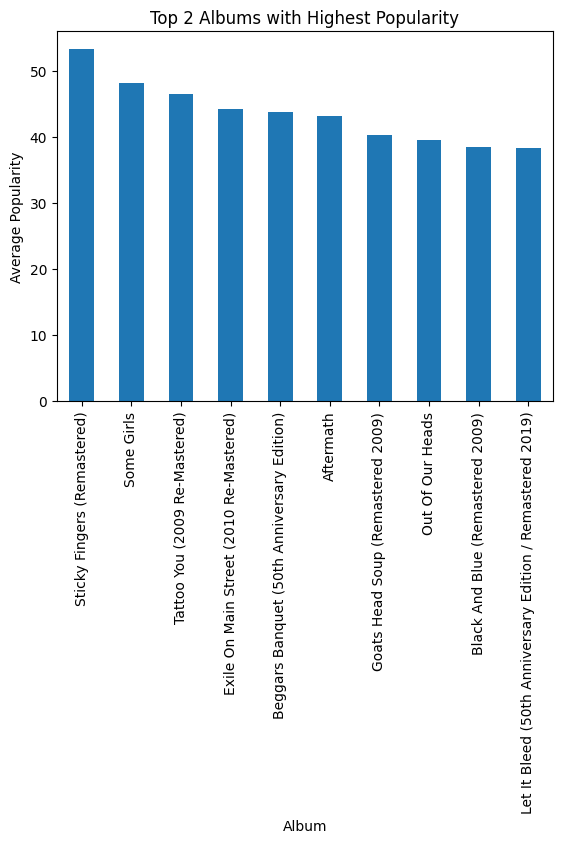

In [22]:
# Feature engineering: Add a column for song popularity category
data['popularity_category'] = pd.cut(data['popularity'], bins=[-1, 25, 50, 75, 100], labels=['Low', 'Medium', 'High', 'Very High'])

# Exploratory Data Analysis
# Visualization: Album recommendations
album_popularity = data.groupby('album')['popularity'].mean().sort_values(ascending=False).head(10)
album_popularity.plot(kind='bar', xlabel='Album', ylabel='Average Popularity', title='Top 2 Albums with Highest Popularity')
plt.show()



__Result:__
- Most popular albums are Sticky Fingers (Remastered) and Some Girls

## b.	Conduct exploratory data analysis to delve into various features of songs, aiming to identify patterns

For simplicity let's group features given.
- Audio Features: Energy, danceability, valence, tempo, loudness, duration
- Metadata: track number, track name, album, release date
- Popularity Indicators: song popularity 

Let's use following methods to analyze features
- Univariable analysis
- Bivariable analysis
- Mutlivariable analysis

__1. Before we begin, let's examine the data to see descriptive statistics for numberical features__

In [5]:
data.info()  # Get a summary of your dataset, including non-null counts and data types
data.describe()  # Get descriptive statistics for numerical features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Unnamed: 0           1610 non-null   int64   
 1   name                 1610 non-null   object  
 2   album                1610 non-null   object  
 3   release_date         1610 non-null   object  
 4   track_number         1610 non-null   int64   
 5   id                   1610 non-null   object  
 6   uri                  1610 non-null   object  
 7   acousticness         1610 non-null   float64 
 8   danceability         1610 non-null   float64 
 9   energy               1610 non-null   float64 
 10  instrumentalness     1610 non-null   float64 
 11  liveness             1610 non-null   float64 
 12  loudness             1610 non-null   float64 
 13  speechiness          1610 non-null   float64 
 14  tempo                1610 non-null   float64 
 15  valence              

,Unnamed: 0,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
count,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.00000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000
mean,804.500000,8.613665,0.250475,0.468860,0.792352,0.164170,0.49173,-6.971615,0.069512,126.082033,0.582165,20.788199,257736.488199
std,464.911282,6.560220,0.227397,0.141775,0.179886,0.276249,0.34910,2.994003,0.051631,29.233483,0.231253,12.426859,108333.474920
min,0.000000,1.000000,0.000009,0.104000,0.141000,0.000000,0.02190,-24.408000,0.023200,46.525000,0.000000,0.000000,21000.000000
25%,402.250000,4.000000,0.058350,0.362250,0.674000,0.000219,0.15300,-8.982500,0.036500,107.390750,0.404250,13.000000,190613.000000
50%,804.500000,7.000000,0.183000,0.458000,0.848500,0.013750,0.37950,-6.523000,0.051200,124.404500,0.583000,20.000000,243093.000000
75%,1206.750000,11.000000,0.403750,0.578000,0.945000,0.179000,0.89375,-4.608750,0.086600,142.355750,0.778000,27.000000,295319.750000
max,1609.000000,47.000000,0.994000,0.887000,0.999000,0.996000,0.99800,-1.014000,0.624000,216.304000,0.974000,80.000000,981866.000000


__2. Univariate Analysis (Single Feature Analysis)__

Let's look at some audio features. Since they are continuous variables, we can use histograms or density plots to analyze their distirubution.

__2.1 Starting from energy analysis__

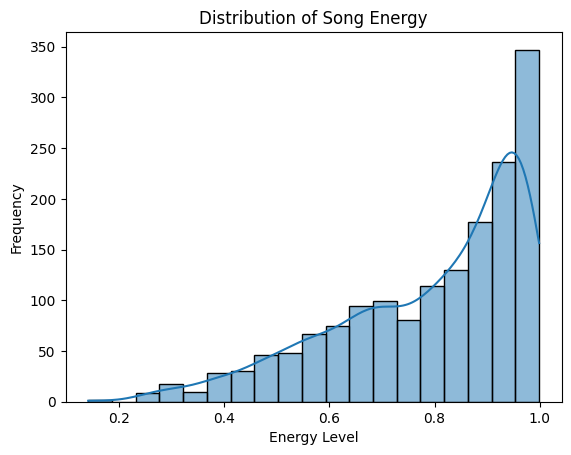

Percentage of songs with energy greater than 0.75: 65.40372670807454%


In [6]:
sns.histplot(data['energy'], kde=True)
plt.title('Distribution of Song Energy')
plt.xlabel('Energy Level')
plt.ylabel('Frequency')
plt.show()
data['energy'].describe()
high_energy_threshold = 0.75  # high energy threshold'
high_energy_percentage = (data['energy'] > high_energy_threshold).mean() * 100

print(f"Percentage of songs with energy greater than {high_energy_threshold}: {high_energy_percentage}%")

Observation: The average energy level across all songs is approximately 0.792, and with over 65% of songs having an energy level greater than 0.75, it can be concluded that the majority of the songs are high energy. 

Let's add another column "energy_category" to see song count for different energy levels

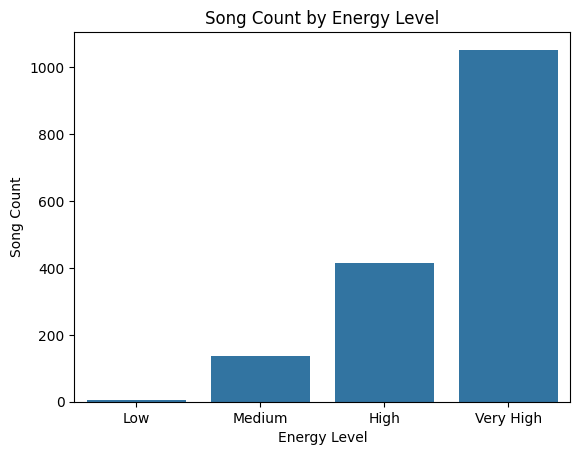

In [7]:
energy_labels = ['Low', 'Medium', 'High', 'Very High']
data['energy_category'] = pd.cut(data['energy'], bins=[0, 0.25, 0.50, 0.75, 1], labels=energy_labels)
sns.countplot(x='energy_category', data=data, order=energy_labels)
plt.title('Song Count by Energy Level')
plt.xlabel('Energy Level')
plt.ylabel('Song Count')
plt.show()

Observation: again, we can see that majoriy of songs are high energy. It would be interesting to see how energy influences popularity, and if the low energy songs are the least popular ones.

__2.2 Now, will look at tempo.__ 

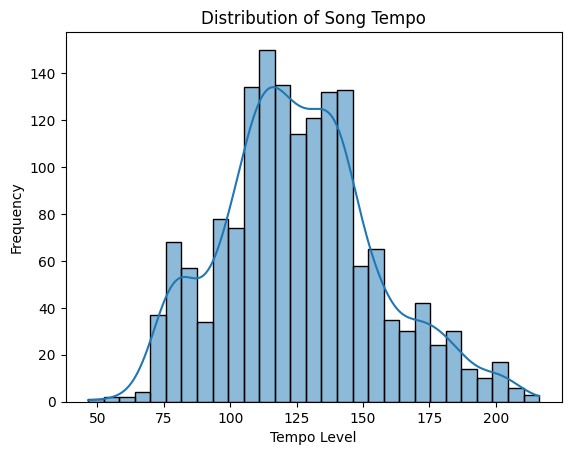

count    1610.000000
mean      126.082033
std        29.233483
min        46.525000
25%       107.390750
50%       124.404500
75%       142.355750
max       216.304000
Name: tempo, dtype: float64

In [8]:
sns.histplot(data['tempo'], kde=True)
plt.title('Distribution of Song Tempo')
plt.xlabel('Tempo Level')
plt.ylabel('Frequency')
plt.show()
data['tempo'].describe()

Observation: with an average tempo of approximately 126 BPM, the majority of the songs fall within a moderate to lively tempo range, typical of many pop and dance tracks.

__2.3 Now, we will look at valence.__

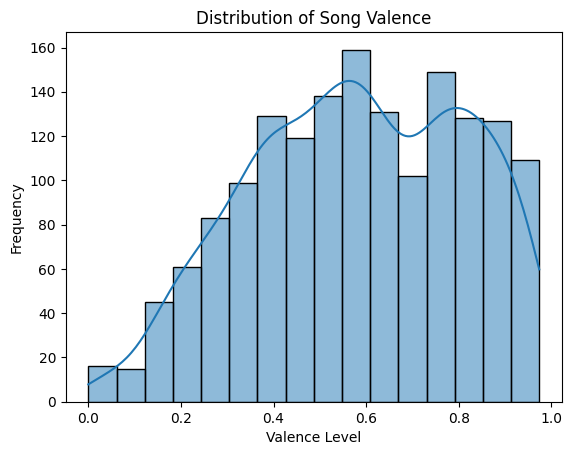

count    1610.000000
mean        0.582165
std         0.231253
min         0.000000
25%         0.404250
50%         0.583000
75%         0.778000
max         0.974000
Name: valence, dtype: float64

In [9]:
sns.histplot(data['valence'], kde=True)
plt.title('Distribution of Song Valence')
plt.xlabel('Valence Level')
plt.ylabel('Frequency')
plt.show()
data['valence'].describe()

Observation: With an average valence of approximately 0.582, the songs generally convey a moderately positive emotional tone, suggesting a slight leaning towards more positive emotional content.

__2.4 Now, let's look at speechiness__

Some info on speechiness. 

Speechiness is a feature measured by Spotify and other music analysis services that indicates the presence of spoken words in a track. It's a quantitative measure that can help distinguish between music with more instrumental parts and tracks that contain more vocal content, such as talk shows, audiobooks, and podcasts, in addition to songs with spoken-word parts, rapping, or singing.

The speechiness score ranges from 0 to 1:

- Closer to 0: The track contains fewer spoken words. Tracks with a low speechiness score are typically most music tracks without spoken words.
- Closer to 1: The track contains a high proportion of spoken words. A value above 0.66 typically indicates that the track is probably made entirely of spoken words.

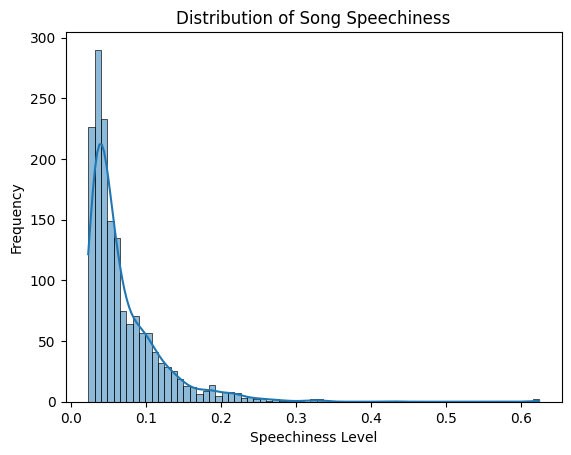

count    1610.000000
mean        0.069512
std         0.051631
min         0.023200
25%         0.036500
50%         0.051200
75%         0.086600
max         0.624000
Name: speechiness, dtype: float64

In [10]:
sns.histplot(data['speechiness'], kde=True)
plt.title('Distribution of Song Speechiness')
plt.xlabel('Speechiness Level')
plt.ylabel('Frequency')
plt.show()
data['speechiness'].describe()

Observation: with an average speechiness score of approximately 0.0695, the dataset underscores tracks where instrumental and melodic elements prevail over speech. Only a small portion of songs exhibit significantly higher speechiness values, with the maximum reaching up to 0.624. This suggests the presence of distinct tracks, possibly with rap or spoken word elements, that stand out from the rest of the dataset.

__2.5. Acousticness__

Acousticness is a measure provided by Spotify and other music analysis platforms that estimates how acoustic a song is. The acousticness feature quantifies the extent to which a track sounds acoustic, as opposed to being produced with electronic instruments. This measure is represented as a value between 0.0 and 1.0:

- Closer to 1.0: The track is more likely to be acoustic, indicating a higher presence of acoustic sounds—these can include non-electric instruments like acoustic guitar, piano, and orchestral strings.
- Closer to 0.0: The track is less likely to be acoustic, suggesting a higher presence of electronic or amplified sounds.

Some thoughts:
A huge part of why I prefer one song over the other is because of the sounds/instrumentation. Sometimes I am in the mood of folk/acoustic songs and sometimes I have preference towards electronic music. I think this feature in itself can be used to create song cohorts.

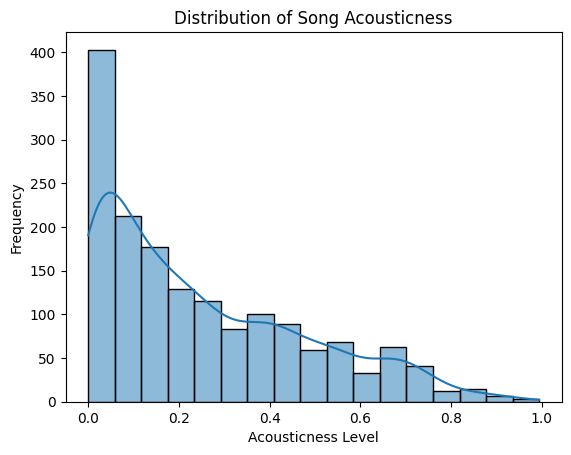

count    1610.000000
mean        0.250475
std         0.227397
min         0.000009
25%         0.058350
50%         0.183000
75%         0.403750
max         0.994000
Name: acousticness, dtype: float64

In [11]:
sns.histplot(data['acousticness'], kde=True)
plt.title('Distribution of Song Acousticness')
plt.xlabel('Acousticness Level')
plt.ylabel('Frequency')
plt.show()
data['acousticness'].describe()

Observation: the dataset spans a broad spectrum of acousticness, from nearly fully electronic tracks to songs that are almost entirely acoustic.
This is great, cause we can definely group songs by acousticness to recommend to users. 

__2.6 Instrumentalness__


Instrumentalness is a feature used by music analysis services like Spotify to predict whether a track contains no vocals. This attribute represents the likelihood of a track being instrumental, and its value ranges from 0.0 to 1.0:

- Closer to 1.0: The track is most likely instrumental. These tracks may have no vocal content at all, or the vocal content is minimal (e.g., some tracks might contain instrumental sections or non-lyrical vocalizations).
- Closer to 0.0: The track is most likely not instrumental, indicating that vocals play a significant part in the track.

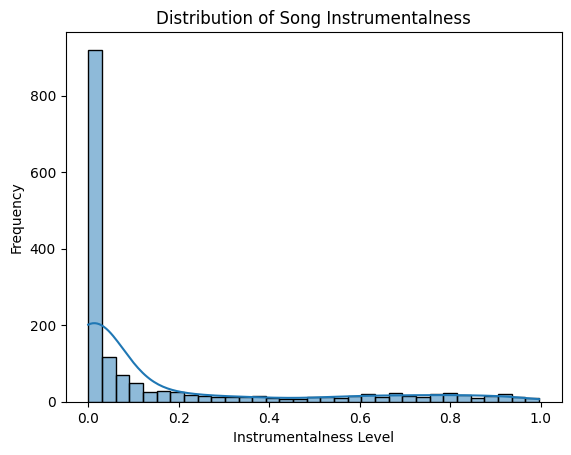

count    1610.000000
mean        0.164170
std         0.276249
min         0.000000
25%         0.000219
50%         0.013750
75%         0.179000
max         0.996000
Name: instrumentalness, dtype: float64

In [12]:
sns.histplot(data['instrumentalness'], kde=True)
plt.title('Distribution of Song Instrumentalness')
plt.xlabel('Instrumentalness Level')
plt.ylabel('Frequency')
plt.show()
data['instrumentalness'].describe()

Observation: the dataset features a wide range of instrumental content, from purely vocal tracks to nearly fully instrumental tracks, as indicated by the broad standard deviation. The dataset leans towards tracks with lower instrumental content, suggesting a predominant presence of vocals.

__3.Explore Relationships Between Features (Bivariate Analysis)__

__3.1 Correlation matrix for numerical values__

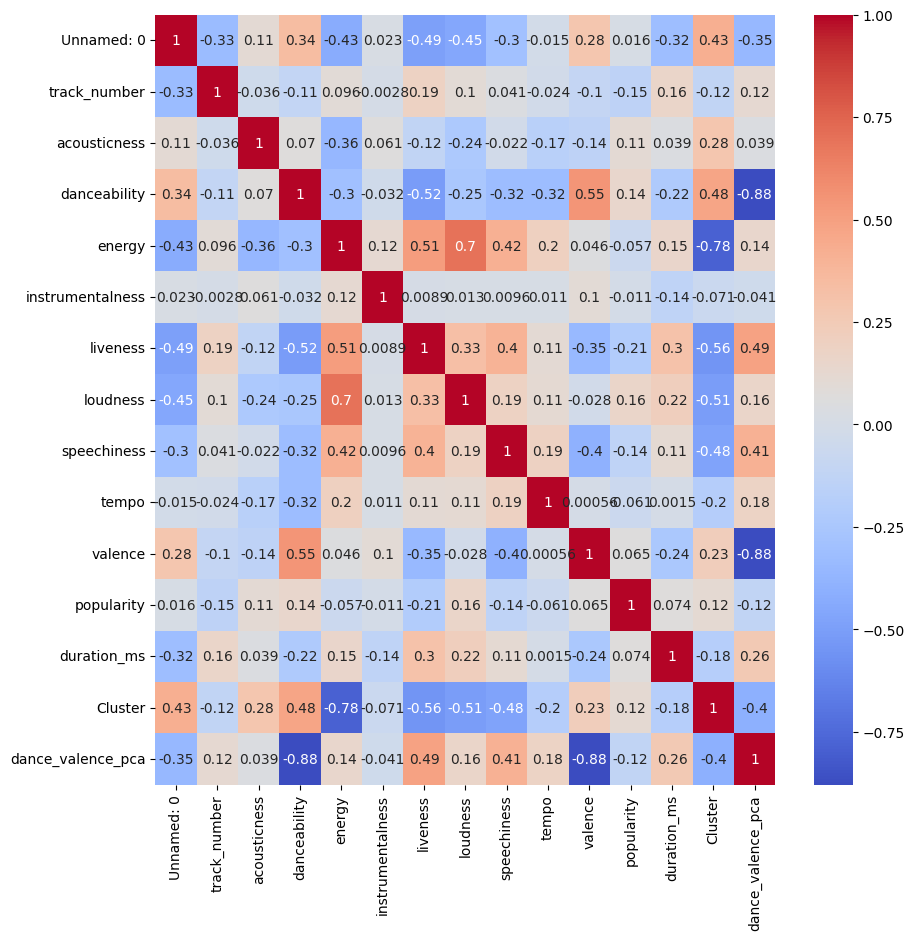

High Correlations:
liveness           danceability   -0.516387
                   energy          0.511188
loudness           energy          0.698039
valence            danceability    0.546210
Cluster            energy         -0.784977
                   liveness       -0.555304
                   loudness       -0.508315
dance_valence_pca  danceability   -0.879264
                   valence        -0.879264
dtype: float64


In [23]:
# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Filter values with high correlation
high_corr = correlation_matrix.where(np.abs(correlation_matrix) > 0.5, np.nan)
high_corr = high_corr.where(np.tril(np.ones(high_corr.shape), k=-1).astype(bool))

# Print high correlations
print("High Correlations:")
print(high_corr.dropna(axis=0, how='all').dropna(axis=1, how='all').stack())

Observation: 
- __Liveness and Danceability (-0.516)__:
This negative correlation suggests that as 'liveness' (the presence of an audience in the recording) increases, 'danceability' (how suitable a track is for dancing) tends to decrease. This might indicate that live recordings, which can include live concerts or live sessions, tend to be less dance-oriented
- __Liveness and Energy (0.511)__:
This positive correlation indicates that tracks with higher 'liveness' scores tend to also have higher 'energy' levels. Live performances often capture the energy of the performance environment, which can translate to higher perceived energy in the recording.
- __Loudness and Energy (0.698)__:
A strong positive correlation between 'loudness' and 'energy' suggests that tracks with higher energy levels also tend to be louder. It does come across that songs that are fast paced, intense are often mastered to have higher loudness levels to enhance their energetic feel.
- __Valence and Danceability (0.546)__:
This positive correlation shows that songs with higher 'valence', which measures the musical positiveness conveyed by a track, tend to also be more danceable. This relationship can be explained by the nature of danceable music often being upbeat and conveying positive emotions.

__4. Investigate Further With Multivariate Analysis__

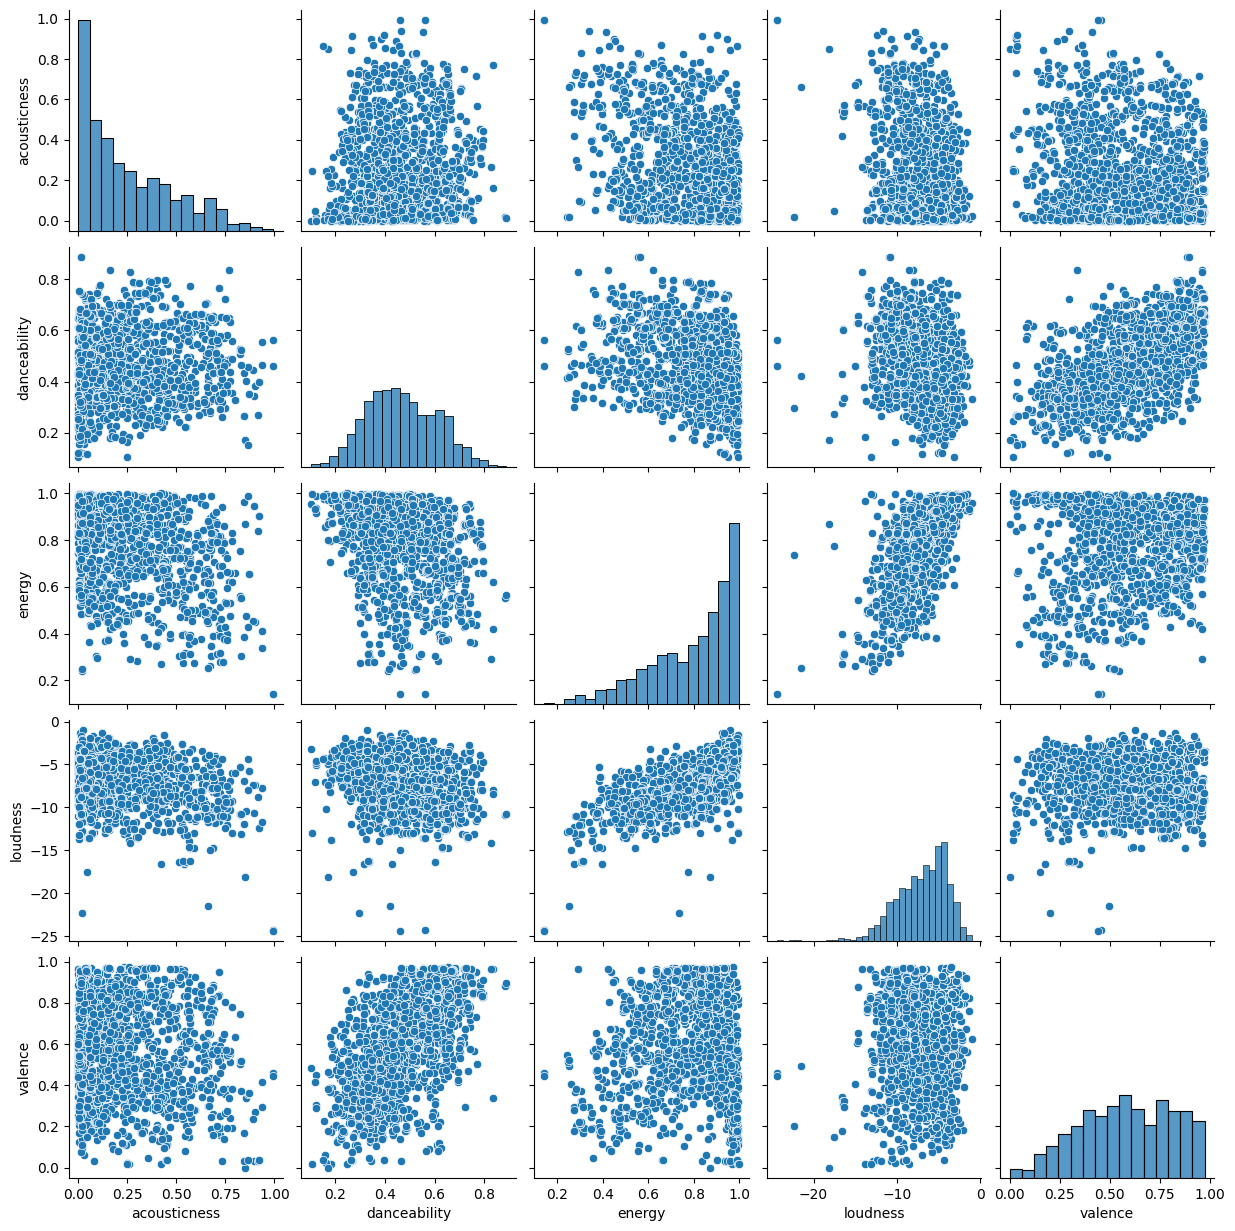

In [14]:
# Visualizations for individual features
sns.pairplot(data[['acousticness', 'danceability', 'energy', 'loudness', 'valence']])
plt.show()

Observation: pairplot visually confirms our correlation matrix findings. It again shows us that certain features like loudness and energy; valence and danceability; liveness and danceability; liveness and energy are highly correlated.

## c. Examine the relationship between a song's popularity and various factors, exploring how this correlation has evolved 

__1. How does song energy influence song's popularity?__

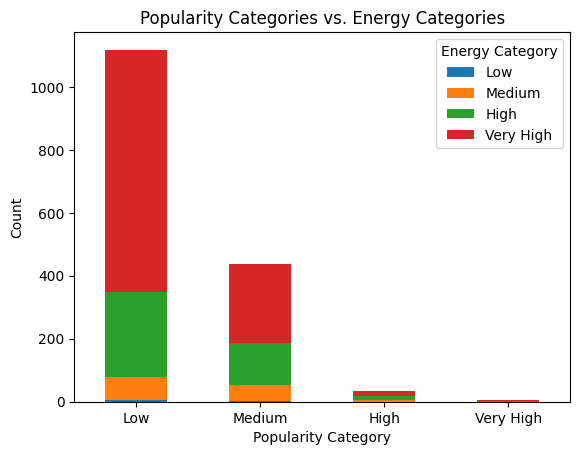

In [15]:
# Feature engineering: Add a column for song popularity category
data['popularity_category'] = pd.cut(data['popularity'], bins=[0, 25, 50, 75, 100], labels=['Low', 'Medium', 'High', 'Very High'])
cross_tab = pd.crosstab(data['popularity_category'], data['energy_category'])

# For a grouped bar chart
cross_tab.plot(kind='bar', stacked=True)
plt.title('Popularity Categories vs. Energy Categories')
plt.xlabel('Popularity Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the category labels horizontal for readability
plt.legend(title='Energy Category')
plt.show()

# print popularity values for low energy songs
low_energy_songs = data[data['energy_category'] == 'Low']
# print(low_energy_songs['popularity'])

# print energy values for high popularity songs
high_popularity_songs = data[data['popularity_category'] == 'High']
# print(high_popularity_songs['energy'])

Observation: since majority of Rolling's stones songs are high energy, it's hard to say whether energy level impacts song's popularity. After printing energy values for most popular songs I was able to see a few songs with medium close to low energy.

__2. How does song tempo influence song's popularity?__

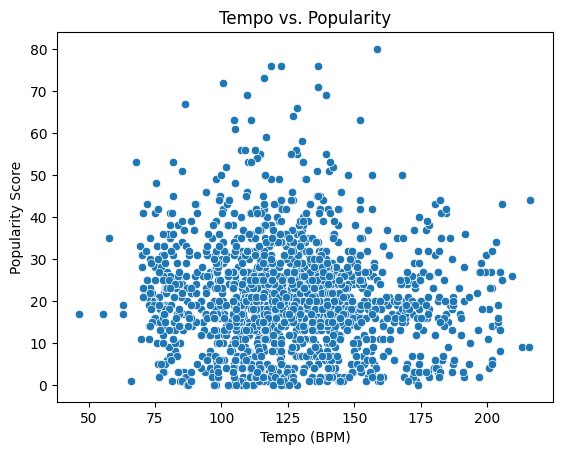

In [16]:
sns.scatterplot(data=data, x='tempo', y='popularity')
plt.title('Tempo vs. Popularity')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Popularity Score')
plt.show()

Observation: we can see that songs of popularity of 60 or higher fall into tempo between [75; 175].
Hard to make any conclusion since majority of songs also fall under [75; 175] tempo. 

__Correlation matrix__: Going back to correlation matrix, we can see that track_number, liveness and speechiness have some negative correlation with song's popularity, this can explained by following:

- Higher the track number on an album, less likely listener will find it. Listener's tend to listen to first fews songs an album. They are placed there for a reason, and they are also songs that end up being most promoted.
- Live recordings are rarely popular, since they end up capturing lots of crowd noise and don't have consistent tempo and lack in other attributes,  that studio recordings have.
- High speechiness is characteristic of specific genres like rap or spoken word, which may have a niche audience compared to other vocal dominant pop songs 

__3. How does speechiness inluence popularity?__

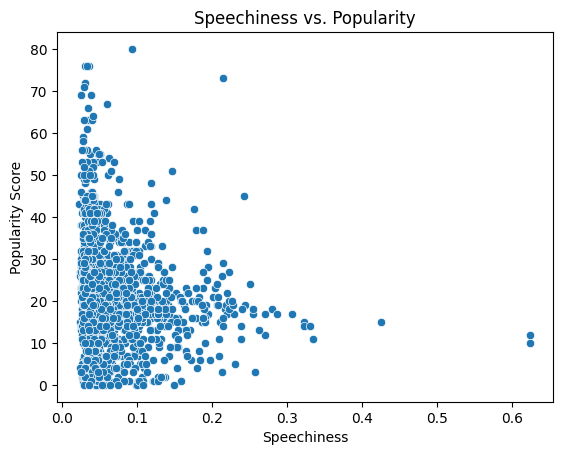

In [17]:
sns.scatterplot(data=data, x='speechiness', y='popularity')
plt.title('Speechiness vs. Popularity')
plt.xlabel('Speechiness')
plt.ylabel('Popularity Score')
plt.show()

Observation: suprisingly, high speechiness songs with speechiness greater than 0.4 are not among the most popular songs. 

# 4.	Perform cluster analysis

__a) Cluser analysis with following features: instrumentalness /speechiness/ acousticness__

Why to use these 3 features?
- After looking at correlation matrix, we can see that all 3 feautures have low correlation coefficient. 
- Together, instrumentalness, speechiness, and acousticness cover a broad spectrum of music's attributes, from its instrumental content and the presence of vocals or spoken words to its electronic versus acoustic nature. This complementary set of features allows us to capture the essence of each song's production and musical style, and hence create meaningful clusters within the dataset.
- Previous analyses have further validated this approach by demonstrating that these features exhibit significant variance and a broad range across the dataset.

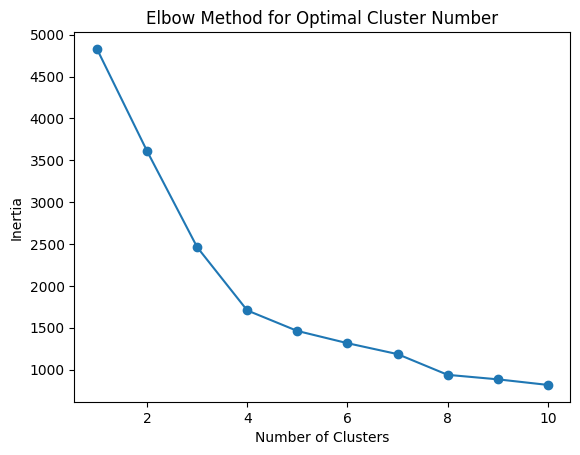

In [18]:
features_df = data[['instrumentalness', 'speechiness', 'acousticness']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Cluster Analysis
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()


         instrumentalness  speechiness  acousticness
Cluster                                             
0                0.052143     0.057717      0.109514
1                0.039431     0.052177      0.527853
2                0.733553     0.062753      0.276606
3                0.087574     0.185781      0.223004


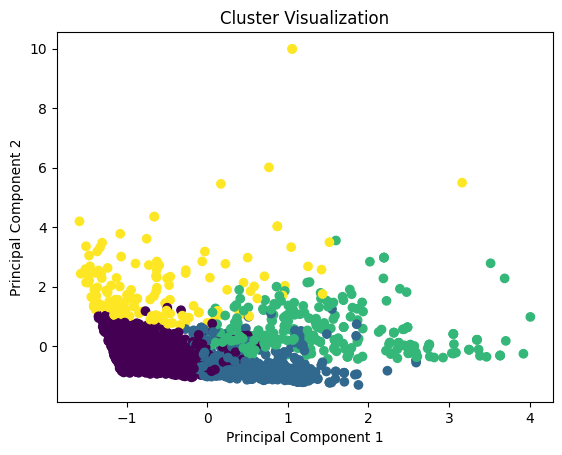

In [19]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to your original DataFrame
data['Cluster'] = clusters

# Calculate the mean value for each feature within each cluster
cluster_means = data.groupby('Cluster')[['instrumentalness', 'speechiness', 'acousticness']].mean()

print(cluster_means)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

plt.scatter(principal_components[:,0], principal_components[:,1], c=data['Cluster'])
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Observation: 

Use of PCA:
- Utilizing PCA as a dimensionality reduction technique was instrumental for our song clustering project, enabling a more digestible visual interpretation of complex feature interactions and significantly enhancing the clarity of our data's multidimensional story.

Cluster 0:
- Instrumentalness (0.052): Relatively low, which means songs in this cluster are not instrumental and contain lots of vocals.
- Speechiness (0.058): Also low, indicating that spoken word content (e.g., talk, rap) is not a defining characteristic of this cluster's songs.
- Acousticness (0.110): Low, implying that these songs are more electronic or produced, with fewer acoustic sounds.
- Interpretation: Cluster 0 seems to represent songs that are more produced or electronic with minimal instrumental or spoken word content, leaning towards standard vocal music with electronic instrumentation.
- Suggested playlists: "Electronic vibes", "Pop hits"


Cluster 1:
- Instrumentalness (0.039): Low, like Cluster 0,  indicating a low presence of instrumental-only tracks.
- Speechiness (0.052): Low, like Cluster 0, suggesting few spoken words.
- Acousticness (0.528): Significantly higher, indicating these songs have more acoustic compared to other clusters.
- Interpretation: Cluster 1 represents songs with a strong acoustic presence, indicating they might be more traditional, folk, or unplugged recordings, but still primarily contain vocals given the low speechiness and instrumentalness.
- Suggested playlists: "Acoustic essentials", "Coffee house"

Cluster 2:
- Instrumentalness (0.734): Very high, suggesting these tracks are mostly or entirely instrumental.
- Speechiness (0.063): Slightly higher but still low, which aligns with the instrumental nature but may include minimal vocal sounds or non-lyrical vocals.
- Acousticness (0.277): Moderate, indicating a mix of acoustic and electronic sounds, but with a strong leaning towards electronic compositions.
- Interpretation: Cluster 2 likely consists of instrumental tracks that could range from electronic to acoustic instrumentals.
- Suggested playlists: "Instrumental study", "Chill instrumentals"

Cluster 3:
- Instrumentalness (0.088): Low, indicating these are not instrumental tracks.
- Speechiness (0.186): Higher than other clusters, suggesting a more significant presence of spoken words, rap, or lyrical delivery.
- Acousticness (0.223): Like cluser 2, moderate, indicating a balance between electronic and acoustic sounds.
- Interpretation: Cluster 3 stands out due to its higher speechiness, suggesting these tracks might include genres with more pronounced lyrical content, such as rap or hip-hop, where speech plays a crucial role in the music. 
- Suggested playlists: "Spoken Word", "Hip-hop and Rap"


__b) Cluster analysis with following features: valence /energy/ danceability__

Valence and danceability are higly correlated, by reducing to one feature we can remove noise and have essential information for grouping songs suitable for positive, danceable playlists. Adding energy to this clustering algorithm can further enhance our groupings suggesting which songs are higly energetic.

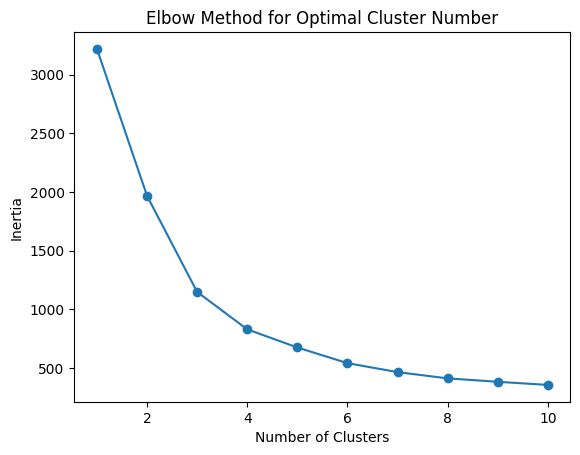

In [20]:
features = data[['danceability', 'valence']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA to reduce 'danceability' and 'valence' to a single component
pca = PCA(n_components=1)
dance_valence_pca = pca.fit_transform(features_scaled)

data['dance_valence_pca'] = dance_valence_pca
features_for_clustering = data[['dance_valence_pca', 'energy']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Cluster Analysis
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()


         dance_valence_pca    energy
Cluster                             
0                 1.070024  0.915208
1                -1.105365  0.837537
2                 0.060057  0.533239


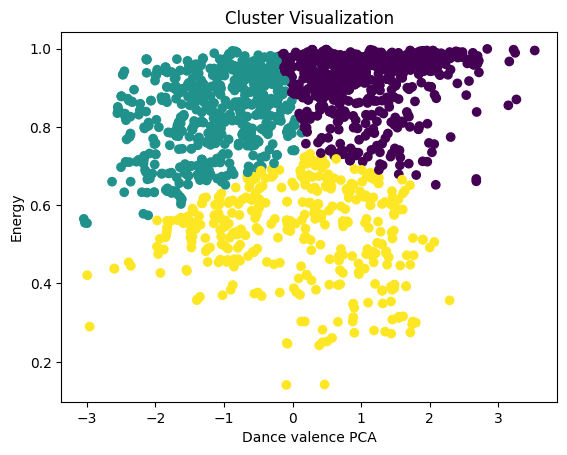

In [21]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to your original DataFrame
data['Cluster'] = clusters

# Calculate the mean value for each feature within each cluster
cluster_means = data.groupby('Cluster')[['dance_valence_pca', 'energy']].mean()

print(cluster_means)

plt.scatter(dance_valence_pca, data['energy'], c=data['Cluster'])
plt.title('Cluster Visualization')
plt.xlabel('Dance valence PCA')
plt.ylabel('Energy')
plt.show()

Observation: 

Use of PCA: for this use case PCA helped us combine 2 highly features into 1, by retaining important information about song's mood and danceability and removing noise.

Cluster 0:
- Dance_Valence PCA Component: Positive values indicate that this cluster has songs with higher combined 'danceability' and 'valence'. This suggests these songs are likely more upbeat and positive, potentially suitable for lively and energetic playlists.
- Energy: The average energy level is high, further reinforcing that this cluster includes songs that are vibrant and dynamic.
- Interprepation: energetic, feel-good songs that might make listeners want to move and have an uplifting effect.
- Suggested playlists: "Party Starters" or "Feel-Good Anthems"

Cluster 1:
- Dance_Valence PCA Component: Negative values suggest that this cluster contains songs with lower 'danceability' and 'valence', which could mean these songs are less upbeat and might have a more relaxed tone.
- Energy: The energy level is still relatively high but slightly lower than Cluster 0, indicating that while these songs may not be as danceable, they still possess a certain level of intensity or drive.
- Interpretation: Less upbeat and possibly with a more complex emotional mix.
- Suggested Playlist: "Easy Listening" or "Indie Chill" 

Cluster 2:
- Dance_Valence PCA Component: Values around zero could mean this cluster represents a mix where songs don't strongly lean towards high or low 'danceability' and 'valence'.
- Energy: The average energy level is lower than the first two clusters, suggesting these songs are more calm and could fit into more laid-back or chill playlists.
- Interpretation: Songs don't distinctly lean towards being either very danceable or very mellow, representing a balanced or neutral mood.
- Suggested Playlist: "Coffeehouse Blend" or "Mid-tempo Moods" 

